# Transfer Learning with Tensorflow Part 1: Feature Extraction 

Transfer Learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working NN architecture which has already learned patterns on similar data to our own, then we can adapt those patterns to our own problem.


## Downloading and becoming one with the data

In [1]:
# Get data (10% of 10 food classes)

import os
import zipfile
import wget

url = 'https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip'
filename = '10_food_classes_10_percent.zip'

# Download only if the file doesn't already exist
if not os.path.exists(filename):
    print("Downloading the file...")
    downloaded_file = wget.download(url)
else:
    print("File already exists, skipping download.")

# Unzip only if the zip file is present
if os.path.exists(filename):
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall()
    print("Extraction complete.")   

File already exists, skipping download.
Extraction complete.


In [2]:
# How many images in each folder? 
import os 

# Walk through 10 percent data directory and list number of files
# Walk through pizza_steak directory and list number of files 
for dirpath, dirnames, filenames in os.walk('10_food_classes_10_percent/'):
    print(f'There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}')

There are 2 directories and 0 images in 10_food_classes_10_percent/
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test\chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test\chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test\fried_rice
There are 0 directories and 250 images in 10_food_classes_10_percent/test\grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test\hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test\ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test\pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test\ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test\steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test\sushi
There are 10 director

## Creating data loaders (preparing the data)

We'll use the `ImageDataGenerator` to load in our images in batches

In [3]:
# Setup data inputs 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32 

train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print('Training images:')
train_data_10_percent = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)

print('Test images:')
test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='rgb'
)



Training images:
Found 750 images belonging to 10 classes.
Test images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model train)

Callbacks are extra functionality you can add to your model to be performed during or after training. Some of the most popular callbacks are :
* Tracking experiments with the `Tensorboard` callback 
* Model checkpoint with the ModelCheckpoing callback 
* Stopping a model from training (before it trains too long and overfits) with the EarlyStopping callback.

In [4]:
# Create TensorBoard callback (functionalized because we need to create a new one for each model)
import datetime 

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f'Saving TensorBoard log files to: {log_dir}')
    return tensorboard_callback

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process excepts the majority of our model's layers are going to come from TensorFlow Hub.


In [5]:
# Let's compare the following two models 

resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://www.kaggle.com/models/tensorflow/efficientnet/TensorFlow2/b0-feature-vector/1"


In [6]:
# Import denpendencies
import tensorflow as tf 
from tensorflow.keras import layers
import tensorflow_hub as hub

print(tf.__version__)
print(hub.__version__)




2.19.1
0.16.1


In [45]:
# Let's make a create_model() function to create a model from a URL 

class HubLayerWrapper(tf.keras.layers.Layer):
    def __init__(self, model_url, trainable=False, **kwargs):
        super(HubLayerWrapper, self).__init__(**kwargs)
        self.hub_layer = hub.KerasLayer(model_url, trainable=trainable)
    
    def call(self, inputs):
        return self.hub_layer(inputs)

        
def create_model(model_url, num_classes=10, IMAGE_SHAPE=(224, 224), probability=0):
    """
    Takes a TensorFlow Hub URL and creates a Keras SEquential model with it.

    Args:
        model_url (str): A Tensorflow Hub feature extraction URL.
        num_classes (int): Number of output neurons in the output layer,
        should be equal to number of target classes, default 10.

    Returns:
        An uncompiled Keras Sequential model with model_url as feature extractor layer 
        and Dense output layer with num_classes output neurons.
    """
    
    feature_extractor_layer = HubLayerWrapper(
        model_url,
        trainable=False,
        name='feature_extraction_layer'
    )
    
    # Create model
    model = tf.keras.Sequential([
        tf.keras.Input(IMAGE_SHAPE + (3,)),
        feature_extractor_layer,
        tf.keras.layers.Dropout(probability),
        layers.Dense(num_classes, activation='softmax', name='output_layer')
    ])
    
    return model


    
    

## Creating ResNet Tensorflow Hub Feature Extraction model

In [8]:
# Create Resnet model 
resnet_model = create_model(resnet_url)

In [46]:
resnet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ feature_extraction_layer             │ (None, 2048)                │               0 │
│ (HubLayerWrapper)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          20,490 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 61,472 (240.13 KB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 40,982 (160.09 KB)

In [10]:
# Compile our resnet model 
resnet_model.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])

In [11]:
resnet_history = resnet_model.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub', experiment_name='resnet50V2')]
)

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20250829-121734


C:\Users\yashs\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - accuracy: 0.3613 - loss: 1.8958 - val_accuracy: 0.6288 - val_loss: 1.2009
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.7440 - loss: 0.8867 - val_accuracy: 0.7312 - val_loss: 0.8349
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.8267 - loss: 0.6061 - val_accuracy: 0.7604 - val_loss: 0.7420
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.8880 - loss: 0.4636 - val_accuracy: 0.7724 - val_loss: 0.7047
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step - accuracy: 0.9240 - loss: 0.3716 - val_accuracy: 0.7840 - val_loss: 0.6615


Wow! 

That. Is. Incredible. Our Transfer learning feature extractor model out performed ALL of the previous models we built by hand... (substantially)
and in a quicker training time.


In [18]:
# Let's createa function to plot our loss curves.
# Plot the validation and training curves separately 
import matplotlib.pyplot as plt
def plot_loss_curves(history):
    """
    Returns seperate loss curves for training and validation metrics.
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss 
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('loss')
    plt.xlabel('epochs')
    plt.legend()

    # Plot Accuracy 
    plt.figure()
    plt.plot(epochs, accuracy, label='training_loss')
    plt.plot(epochs, val_accuracy, label='val_loss')
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.legend();



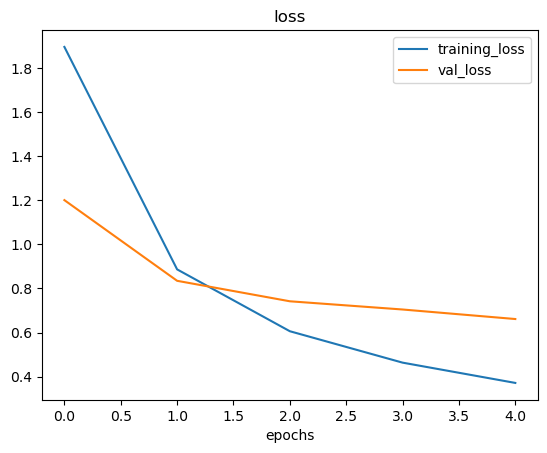

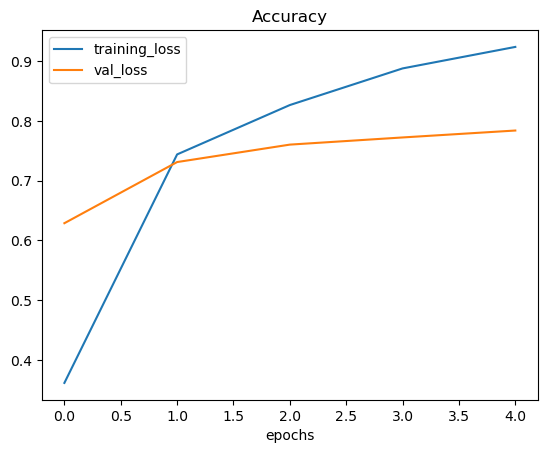

In [19]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 Tensorflow hub feature extraction model

In [20]:
effnet_model = create_model(efficientnet_url)

In [21]:
effnet_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ feature_extraction_layer             │ (None, 1280)                │               0 │
│ (HubLayerWrapper)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,810 (50.04 KB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Compile our resnet model 
effnet_model.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['accuracy'])

In [23]:
effnet_history = effnet_model.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub', experiment_name='efficientnetB0')]
)

Saving TensorBoard log files to: tensorflow_hub/efficientnetB0/20250829-122616
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4680 - loss: 1.8514 - val_accuracy: 0.7452 - val_loss: 1.3010
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.7627 - loss: 1.0739 - val_accuracy: 0.8232 - val_loss: 0.8668
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8200 - loss: 0.7666 - val_accuracy: 0.8408 - val_loss: 0.6960
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8680 - loss: 0.6177 - val_accuracy: 0.8552 - val_loss: 0.6068
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.8840 - loss: 0.5240 - val_accuracy: 0.8628 - val_loss: 0.5539


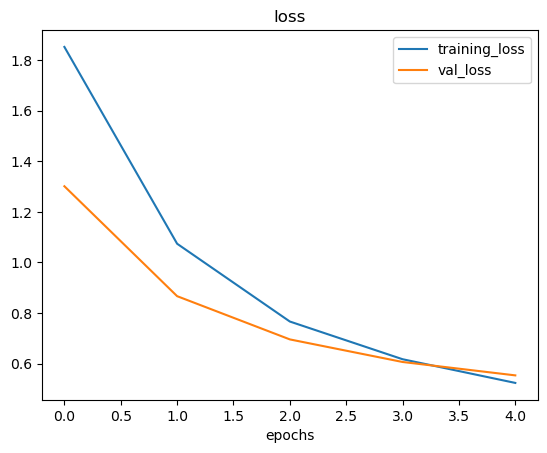

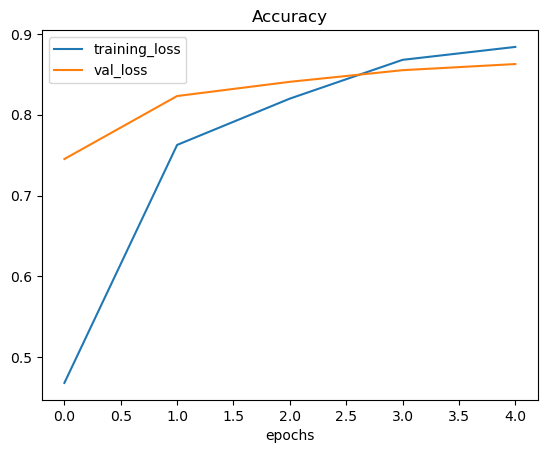

In [24]:
# Visualize the loss curves 
plot_loss_curves(effnet_history)

**WOW very few overfitting we can manage that it seems better than resnet with high validation accuracy and faster**

## Different types of transfer learning

* "As is" transfer learning - using an existing model with no changes what so ever. (e.g Using ImageNet model on 1000 Imagenet classes, none of your own )
* 'Feature extraction' transfer learning - use the prelearned patterns of existing model (e.g. EfficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (eg. 1000 classes -> 10 classes of food)
* 'Fine-tuning' transfer learning - use the prelearned patterns of an existing model and fine tune many or all of the underlying layers (including new output layers)

## Comparing our models results using TensorBoard

In [51]:
%load_ext tensorboard
%tensorboard --logdir tensorflow_hub

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 11936), started 0:27:39 ago. (Use '!kill 11936' to kill it.)

### Creating and testing Mobilenet_v2 Tensorflow hub feature extraction model

In [47]:
mobilenet_url = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5'
mobile_net = create_model(mobilenet_url, IMAGE_SHAPE=(224, 224), probability=0.3)

In [48]:
mobile_net.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ feature_extraction_layer             │ (None, 1280)                │               0 │
│ (HubLayerWrapper)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │          12,810 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,810 (50.04 KB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Compile the model 
mobile_net.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# Fit the model 
mobilenet_history = mobile_net.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data,
    callbacks=[create_tensorboard_callback(dir_name='tensorflow_hub', experiment_name='mobilenetV2')]
)

Saving TensorBoard log files to: tensorflow_hub/mobilenetV2/20250829-132422
Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.2400 - loss: 2.2785 - val_accuracy: 0.5696 - val_loss: 1.4446
Epoch 2/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - accuracy: 0.5827 - loss: 1.2877 - val_accuracy: 0.7096 - val_loss: 0.9947
Epoch 3/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 993ms/step - accuracy: 0.7107 - loss: 0.9252 - val_accuracy: 0.7732 - val_loss: 0.7975
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 992ms/step - accuracy: 0.7827 - loss: 0.7481 - val_accuracy: 0.7740 - val_loss: 0.7358
Epoch 5/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.8240 - loss: 0.6251 - val_accuracy: 0.7988 - val_loss: 0.6645


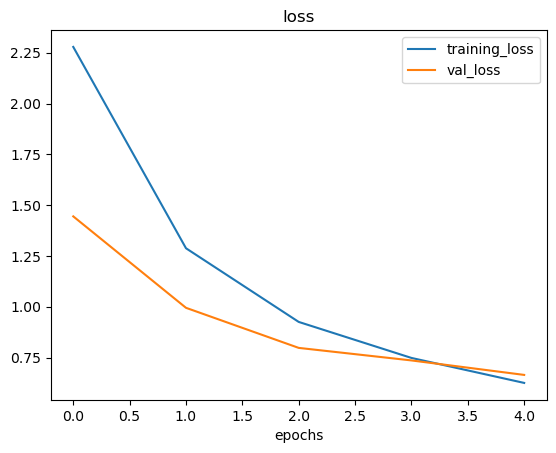

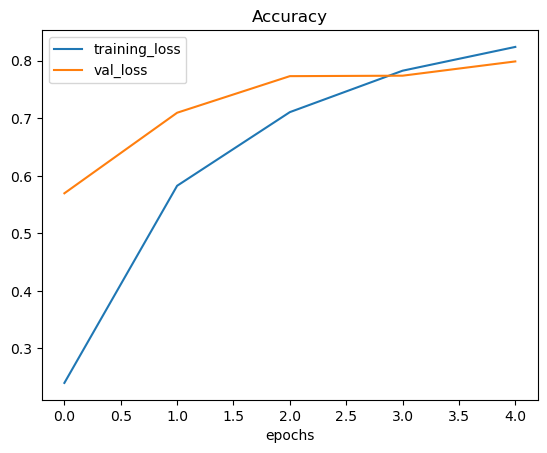

In [50]:
# Let visualize the training curves 
plot_loss_curves(mobilenet_history)